## Pre-Lab

Before this lab, each group should have collected enough measurements of faces to give us 150-200 pairs. For each person, we need the following as precisely as possible:

* Circumference of head (under the top of the ears);
* Height of head (from chin to top of nose).

Either inches or centimeters are fine. Centimeters may well be easier to measure and work with. You will send the measurements to your lab instructor, who will collate them and send you back an array containing all of them, with circumference data in the first row and height in the second.

> ## Make a copy of this notebook (File menu -> Make a Copy...)

## What is Facial Recognition?

There are two goals to facial recognition:
1. Decide whether a given image is indeed a face; and
1. Figure out whose face it is.

We will look at Goal 2 next time and make significant progress toward it (under certain conditions). Today, we'll get an idea of how to think about Goal 1 mathematically in a somewhat simplified way, and say a few words about generalizing our solution. We will more-or-less be following parts of [Muller, Magaia, and Herbst, 2004](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517). We will refer to this paper as MMH04.

From that paper:

>"Let us consider the problem of finding a face in an image. One possible
(rather naive) approach would be to identify a number of objects that might qualify
and to measure their width and height. It is easy to imagine that the measurements
of any face should fall within a certain range. Anything outside the “typical” range
can be discarded. Anything inside the range can then be investigated in more detail
for further face-like characteristics. The problem is to find the “typical” range of
measurements for faces. <br><br>
>Although this example is contrived—the number of features we measure is too
low—it is not entirely unrealistic. In fact, one of the earliest identification systems,
and at the time a serious rival for fingerprints, was based on a comprehensive mea-
surements of individuals. The system developed by Alphonse Bertillion in France
during the 1870s employed eleven separate measurements of an individual: height,
length, and breadth of head; length and breadth of ear; length from elbow to end
of middle finger; lengths of middle and ring fingers; length of left foot; length of
the trunk; and length of outstretched arms from middle fingertip to middle fingertip.
Apart from being able to distinguish between different individuals, it also allowed a
classification system that enabled Bertillion to quickly locate the file of a criminal,
given just the measurements. The system was so successful that France was one of
the last countries to adopt fingerprints for personal identification." ([MMH04](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517) page 524.)


## Inspecting the Data

**Question 1** Create a scatter plot of height of face (on the $y$-axis) vs. circumference of face using *matplotlib*. We want to see the positions of the points relative to the origin, so set the $x$ and $y$ axes to include it. We will be plotting a number of related plots, so it will be useful to have subplots. A $3\times 2$ grid will probably do the trick.

A quick *matplotlib* subplots helper:
```python
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(m, n)        # create a figure and m x n subplots in a grid
fig.set_size_inches(width,height)   # set the overall height and width of the figure
```

At this point, *ax* is an $m\times n$ array of sets of axes, each of which can be used to plot things. You can do things like:
```python
ax[0,0].axis([xmin,xmax,ymin,ymax]) # set min and max for x and y axes
ax[0,0].set_aspect('equal')         # set an 1-1 aspect ratio
ax[0,0].scatter(xs,ys)              # plot a scatter plot
```

By default, *matplotlib* puts axes on the edges of the plot. If you prefer the more traditional axes going through the origin, I wrote a function to do this:
```python
def middleaxes(plot):
    # Given a matplotlib plot, this sets the axes to be centered at the origin
    # Returns the plot
    plot.spines['left'].set_position('zero')
    plot.spines['right'].set_color('none')
    plot.yaxis.tick_left()
    plot.spines['bottom'].set_position('zero')
    plot.spines['top'].set_color('none')
    plot.xaxis.tick_bottom()
    
    return plot

middleaxes(ax[0,0])
```


<IPython.core.display.Javascript object>


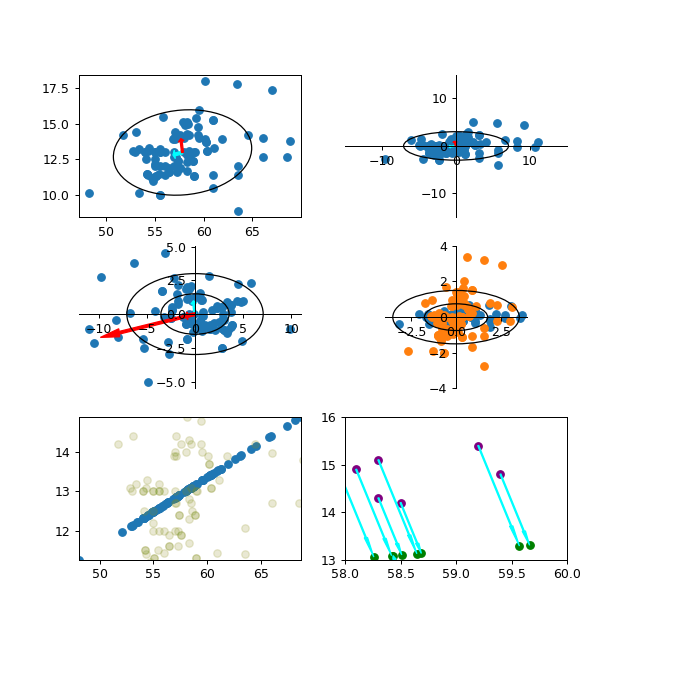

In [320]:
import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt

#function to set x,y axes to center around origin 
def middleaxes(plot):
    # Given a matplotlib plot, this sets the axes to be centered at the origin
    # Returns the plot
    plot.spines['left'].set_position('zero')
    plot.spines['right'].set_color('none')
    plot.yaxis.tick_left()
    plot.spines['bottom'].set_position('zero')
    plot.spines['top'].set_color('none')
    plot.xaxis.tick_bottom()

    return plot

#get faces 
faces=np.genfromtxt('measurementsf2019.csv',delimiter=',')

#Question 1: Create Scatterplot 
fig, ax = plt.subplots(3, 2)        # create a figure and m x n subplots in a grid
fig.set_size_inches(7,7)   # set the overall height and width of the figure

faces_circ = faces[:,0]
faces_height = faces[:,1]


ax[0,0].scatter(faces_circ,faces_height)

**Question 2** Comment briefly on your scatter plot. More precisely, what can you say about where on the plane the points that represent heads are located?

Our goal today will be to compute an ellipse that encompasses most of the data. We are restricting ourselves to two dimensions simply for ease of visualization. While this is not sufficient for identification, we will be developing the tools and ideas that underlie this approach.

**Question 3** The first thing we want to do is to move the data to be centered around the origin. To do so, find the average circumference and height. Then create a new array by subtracting the average.  See the very first lab, under *Column and Row Aggregation* and *Broadcasting* if you need a reminder of how to do this). Finally, plot the new points.

Note that we can reuse our figure from above:
```python
ax[0,1].scatter(...)   # plot a scatter plot on another set of axes
...                    # Do more stuff to set up the plot
fig                    # redisplay the figure (including the scatter plot already created)
                       # Note that this also updates the figure in the previous cell, as they're the same.
```

After you do this, set both scatter plots to have the same ranges, so we can compare the two visually. Note that you will need to change the limits on both sets of axes.

In [321]:
#Question 3

#get average height, circumference
avg_circ = faces[:,0].mean(axis=0)
avg_height = faces[:,1].mean(axis=0)

#center data around origin 
origin_centered_faces = np.copy(faces)
origin_centered_faces[:,0] -= avg_circ
origin_centered_faces[:,1] -= avg_height

#separate x,y values
origin_faces_circ = origin_centered_faces[:,0]
origin_faces_height = origin_centered_faces[:,1]

#center around origin 
middleaxes(ax[0,1])

#plot data 
ax[0,1].scatter(origin_faces_circ,origin_faces_height)

## Principal Component Analysis

An ellipse is defined by its center, the length of its two radii and how much it is rotated. 

**Question 4** What is the center of our ellipse?

Our strategy will be to use SVD to find the *principal directions* of the data. That is, we will find the direction in which the data has the most variation (the *first principal direction*) then look at the variation along a vector orthogonal to that (the *second principal direction*).

**Question 5** Calculate the SVD of your normalized data array matrix, storing your results in matrices named *U*, *S*, and *Vt* (recall that the `np.linalg.svd(A)` command returns $V^T$, not $V$). Use the syntax `np.linalg.svd(A,full_matrices=False)` as we will want the reduced SVD here.

In [322]:
#Question 5 

#fix shape of data to be 2xn not nx2
origin_centered_faces = origin_centered_faces.T

#calculate SVD of normalized data 
U,S,Vt = np.linalg.svd(origin_centered_faces,full_matrices=False) #Take SVD of A.T to make U 2x2 

### A Quick Detour: Rotation and Reflection Matrices

**Question 6** Recall that any orthogonal matrix satisfies $A^TA=I$. Use this fact to show that any orthogonal matrix has determinant $\pm 1$.

This is because det(AB) = det(A)det(B), det(A^-1) = 1/det(A), and det(A^-1) = det(A) when A is orthogonal

**Question 7** 
* Suppose that the matrix $\begin{bmatrix}a&b\\c&d\end{bmatrix}$ is orthogonal. What can you say about the following quantities? Explain.
  * $a^2+c^2$: Length of vector (a c) squared
  * $b^2+d^2$: Length of vector (b d) squared
  * $ab+cd$: Dot product of vectors (a c) and (b d)<br><br>
* Why do all the entries have to be between $-1$ and $1$? Because the columns of an orthogonal matrix are orthogonal unit vectors<br><br>
* Let $a=\cos\theta$ for some angle $\theta$ between $0$ and $\pi$. Why must it be true that $c=\pm\sin\theta$?<br><br>

In fact, the matrix must take one of the following forms: <br><br>$$A=\begin{bmatrix}\cos\theta & -\sin\theta \\ \sin\theta & \cos\theta\end{bmatrix},B=\begin{bmatrix}\cos\theta & \sin\theta \\ -\sin\theta & \cos\theta\end{bmatrix},C=\begin{bmatrix}\cos\theta & \sin\theta \\ \sin\theta & -\cos\theta\end{bmatrix},D=\begin{bmatrix}\cos\theta & -\sin\theta \\ -\sin\theta & -\cos\theta\end{bmatrix}$$ <br><br>
* Consider the first two possibilities. Note that both have determinant 1. Let $e_1=\begin{bmatrix}1\\0\end{bmatrix}$ and $e_2=\begin{bmatrix}0\\1\end{bmatrix}$. Draw two sets of axes and label these two vectors on each them. Compute $Ae_1$ and $Ae_2$ and add them to your first set of axes, and do the same with $Be_1$ and $Be_2$ on your second. By examining your drawings, answer the question: What is the effect of multiplying a vector $v\in\mathbb{R}^2$ by A? What about B?

> **We conclude that any orthogonal $2\times 2$ matrix whose determinant is $1$ is a *rotation matrix*.**

**Question 8** Explain why it makes geometric sense that $A=B^T$. (Hint: remember they're orthogonal!)

**Question 9** 
* What is the action of the matrix $R=\begin{bmatrix}1&0\\0&-1\end{bmatrix}$ on the plane?<br><br>
* Compute $AR$ and $BR$. Compare your answers to $C$ and $D$.<br><br>
* Complete the following: <br><br>
  * Matrix $C$'s action is to first reflect the plane in the $\underline{\hspace{1in}}$, then rotate by $\theta$ $\underline{\hspace{1in}}$ (clockwise or anticlockwise).<br><br>
  * Matrix $D$'s action is to first reflect the plane in the $\underline{\hspace{1in}}$, then rotate by $\theta$ $\underline{\hspace{1in}}$ (clockwise or anticlockwise).<br><br>
  * Remembering again that $C$ is orthogonal, and that $C^T=R^TA^T$, describe the action of $C^T$ on the plane. Do the same for $D$.<br><br>

Note that $C^T=C$ and $D^T=D$! So the inverse actions must be the same as the original ones. In fact:

> **The action of any orthogonal $2\times 2$ matrix whose determinant is $-1$ can be expressed as a single reflection.**

(We will show this on the homework.)

### Back to the Data

**Question 10** Recall that if $A=USV^T$ is the SVD of an $m\times n$ matrix, then $U$ is an $m\times m$ orthogonal matrix. In the case of our data, $U$ is a $2\times 2$ orthogonal matrix, so it must have one of the four forms above. By identifying the form of $U$, explain the action of multiplying it by a vector in the plane in terms of rotations and/or reflections. Do the same for $U^T$. Be sure to find the angle involved. You may find the commands `np.arccos(x)` and `np.degrees(rad)` useful.

**Question 11** Look back at your plots and try to figure out would happen to the shape of your normalized data if you multiplied your data matrix by $U^T$. Then create a new array $U^TX$ (where $X$ is your normalized data) and plot it on the third set of axes. Adjust the ranges of all three sets of axes if needed. Compare your plot of the normalized data points to this new plot. Specifically, pick a few of the more extreme points and see where they went. Make sure your observations line up with the action you deduced for $U^T$!

<IPython.core.display.Javascript object>


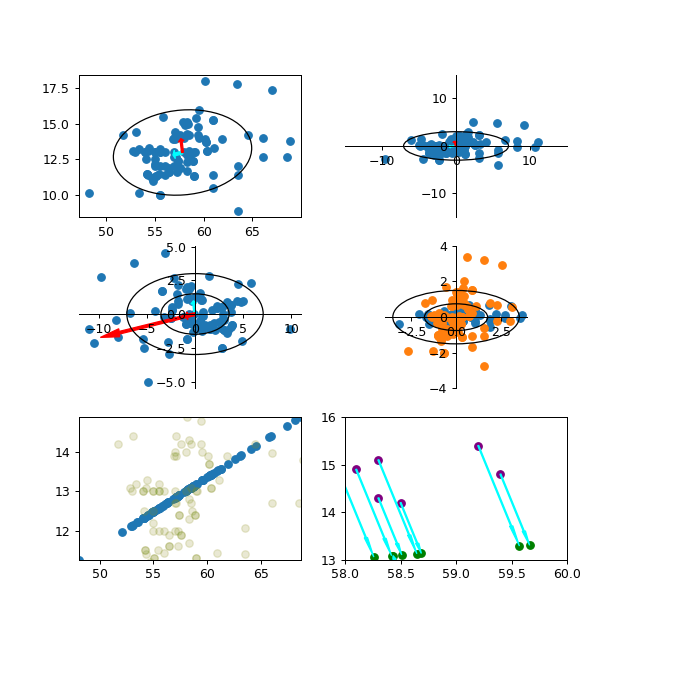

In [323]:
# Question 11

#multiply by U.T
UtX = origin_centered_faces.T @ U

#separate x,y values
UtX_circ = UtX[:,0] 
UtX_height = UtX[:,1]  

#center around origin 
middleaxes(ax[1,0])
#ax[1,0].set_aspect('equal')         # set an 1-1 aspect ratio
#ax[1,0].axis([-7,7,-5,5])

#plot data 
ax[1,0].scatter(UtX_circ,UtX_height)
fig

### Another View on Rotations

Note that since the action of $U$ maps the unit vector along the $x$ axis to the first principal direction, and the unit vector along the $y$ axis to the second, the columns of $U$ must be exactly the unit vectors along those principal directions. (Note: if this is confusing to you, multiply $U$ by the standard unit vectors. Make sure you understand it.)

That means that we can plot the principal directions!

**Question 12** *Matplotlib*'s way of adding objects (like arrows and ellipses) to axes is called *patches*. The following code will add an arrow from $(1,2)$ to $(1+0.5,2+0.7)=(1.5,2.7)$ to an axes object:
```python
from matplotlib.patches import Arrow
arr = Arrow(1,2,0.5,0.7)      # Declare an arrow patch
                              # You can add things like color='cyan' and width=0.25 if you like

ax[0,1].add_patch(arr)        # Add the patch to an existing axes
```
Add arrows to the first two plots indicating the principal directions. You will need to think about where to place the arrows and how long to make them so that they are clear on your plots. Using two different colors will be useful. Lastly, add the corresponding arrows in the third plot, making sure the colors align. Write down some observations regarding the principal directions.

-0.9849029512893032
-0.17310741330636417


<IPython.core.display.Javascript object>


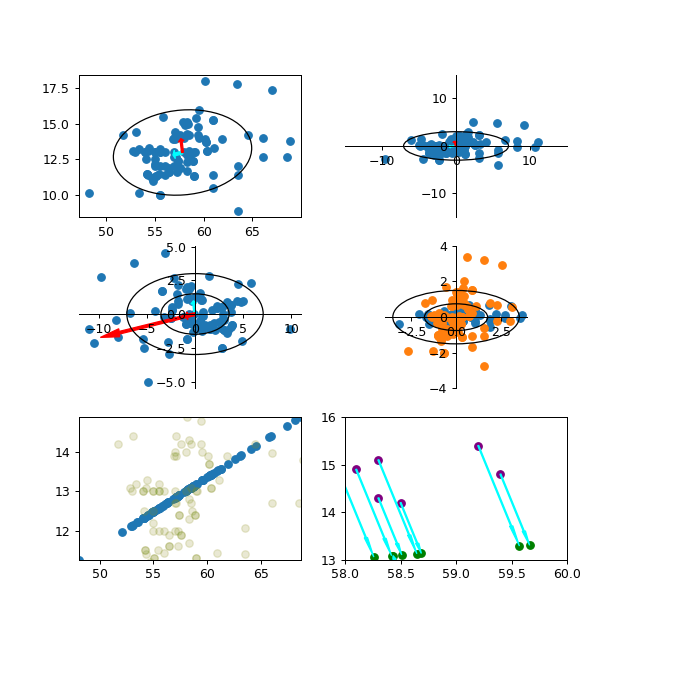

In [324]:
from matplotlib.patches import Arrow
#Question 12

ax[0,0].add_patch(Arrow(avg_circ, avg_height, U[0,0], U[1,0], color="cyan"))
ax[0,0].add_patch(Arrow(avg_circ, avg_height, U[1,0], U[1,1], color="red"))
ax[0,1].add_patch(Arrow(0,0,U[0,0],U[1,0], color="cyan"))
ax[0,1].add_patch(Arrow(0,0,U[1,0],U[1,1], color="red"))

ax[1,0].add_patch(Arrow(0,0,U.T[0,0], U.T[0,1], color="red"))
ax[1,0].add_patch(Arrow(0,0,U.T[1,0], U.T[1,1], color="cyan"))



print(U[0][0])
print(U[0][1])
arr = Arrow(0,0,U[0][0]*10,U[0][1]*10,color="red")      # Declare an arrow patch
                              # You can add things like color='cyan' and width=0.25 if you like

ax[1,0].add_patch(arr)        # Add the patch to an existing axes
fig

### Understanding the Spread

Our next task is to draw an ellipse that encompasses most of the data. The axes of the ellipse will be given by the principal directions. The length of those axes (or radii) should be such that most the data falls inside it. Note that the data is far more spread along the first principal axes than the second. This is a feature of SVD!

As we discussed in the last lab, the singular values (entries of $S$) are closely connected to the spread of the data along the corresponding directions. In fact, we can do better:

 >**Singular Values and Spread**: If we have $n$ data points, the standard deviation of the data along the $i^{th}$ principal direction is $$\sigma_i=\frac{1}{\sqrt{n}}s_i,$$ where $s_i$ is the $i^{th}$ singular value.
 
If data is normally distributed (which is a reasonable assumption in this case), then around $86\%$ of the data will fall within two standard deviations of the mean. (Note: this is true in 2-D. The corresponding percentage in 1-D is around $95\%$. It decreases with increasing dimension.)

**Question 13** The following *Matplotlib* code creates an ellipse centered at *(x,y)*, with **diameter** *r1* in the horizontal direction and *r2* in the vertical direction:
```python
from matplotlib.patches import Ellipse

E = Ellipse(xy=(x,y),width=r1,height=r2)     # Note: we can make the ellipse transparent by adding
                                             # alpha = 0.2 to its parameters, and set its color
```
Add an ellipse whose radii are twice the corresponding standard deviations to the third plot. Make it transparent so you can see the underlying data points.

3.545590206276117 1.4970345519432005


<IPython.core.display.Javascript object>


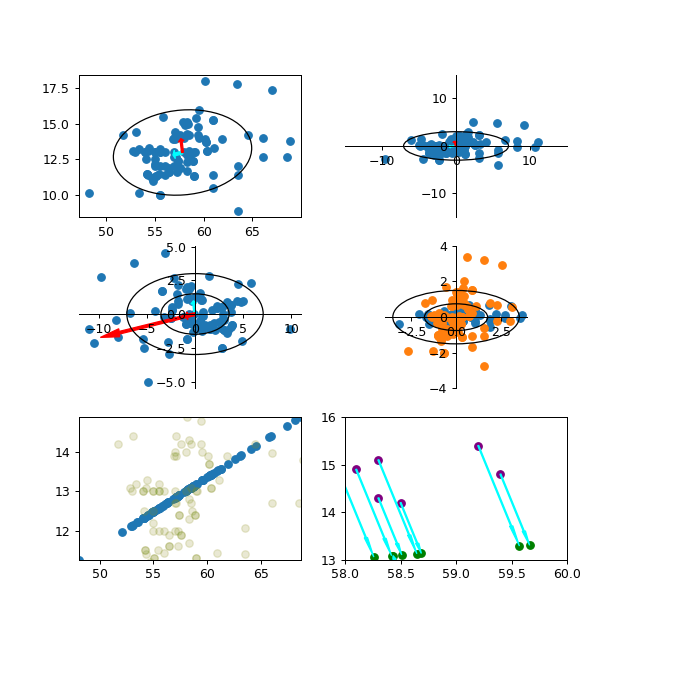

In [332]:
from matplotlib.patches import Ellipse

s1 = S[0]/np.sqrt(101)
s2 = S[1]/np.sqrt(101)

print(s1, s2)

ax[1,0].add_patch(Ellipse(xy=(0,0), width=2*s1, height=2*s2, fill=False))
fig

**Question 14** We can rotate the ellipse by adding the option *angle=ang* to the ellipse (where *ang* is in degrees). Compute the angle you need to rotate the ellipse to encompass the original data points (hint: you pretty much already did this). Then create ellipse patches for the first and second plots like you did in the last question for the third. Also add arrows showing where the two principal directions map to.

<IPython.core.display.Javascript object>


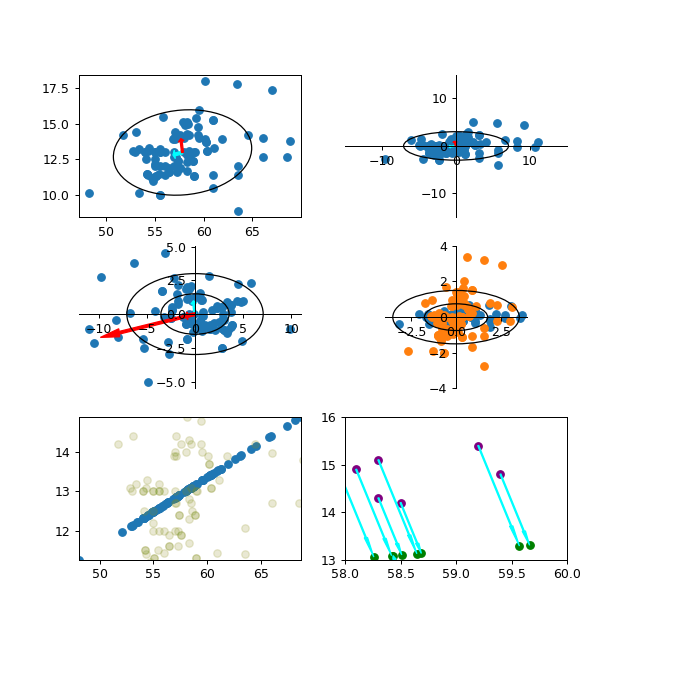

In [326]:
ax[0,1].add_patch(Ellipse(xy=(0,0), width=2*s1, height=2*s2, fill=False))
ax[0,0].add_patch(Ellipse(xy=(avg_circ, avg_height), width=2*s1, height=2*s2, fill=False, angle=np.arccos(U[0,0])))
fig

### What is a Face?

Since the two standard deviation ellipse encompasses around 86% of faces, if a given circumference/height measurement falls outside it, there is a less than 14% chance the object represented is a face. If we increase this to three standard deviations, the chance falls to less than 1.2%. So it will be useful to be able to decide if a given measurement pair is inside the ellipse.

**Question 15** Consider the normalized and rotated data plotted in the third scatter plot. If we were to compress the $x$ values of the points by $\sigma_1$ and the $y$ values by $\sigma_2$, what would happen to the ellipse? Create a new matrix by doing this, and plot the points on the fourth axes. Add in a patch representing the transformed ellipse.

<IPython.core.display.Javascript object>


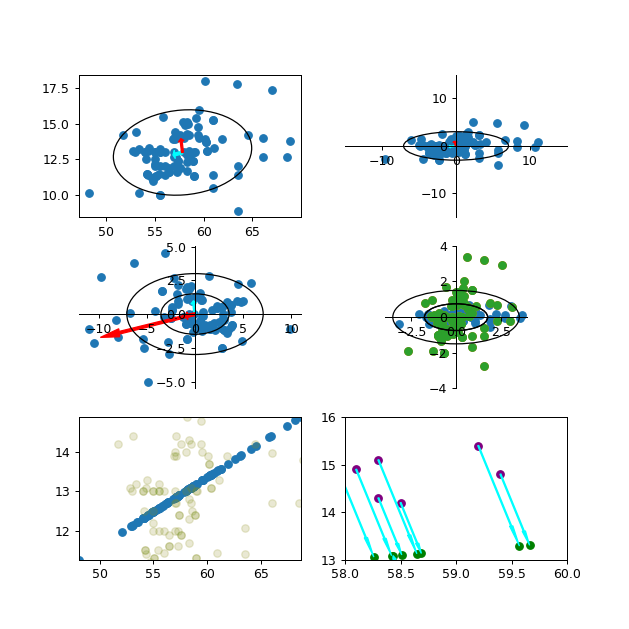

In [334]:
#Question 15
compressed = [origin_centered_faces[0]*1/s1, origin_centered_faces[1]*1/s2]
ax[1,1].set_aspect('equal')         # set an 1-1 aspect ratio
ax[1,1].scatter(compressed[0], compressed[1])
fig.set_size_inches(7,7)   # set the overall height and width of the figure
ax[1,1].axis([-4,4,-4,4])
middleaxes(ax[1,1])

ax[1,1].add_patch(Ellipse(xy=(0,0), width=s1, height=s2, fill=False))
fig

**Question 16** Given a cirumference/height measurement $(w,h)$, describe how you would use the SVD decompostion above to decide whether it falls within the two (or three) standard deviation ellipse.

1) Subtract w from the average circumference measurement, subtract h from the average height measurement to center the vector around the origin.

2) Compute U^T*X, where U^T is the transpose of U which is computed via the SVD of all of the face measurements. 

3) Plot an elipse on top of all of the data and the given vector (w,h) where the radii of the elipse are 2 times the standard deviation of the data in both principal directions. 

4) if (w,h) is contained inside this elipse, it is likely a face. If it does not, it probably is not a face

### Projecting the Data

**Question 17** Suppose the the second entry in *S* is very small compared to the first. What can you say about the shape of the enclosing ellipse? Use your `SVDRebuild(U,S,V,k)` function to compute $U_1S_1V^T_1$ and plot the data points (don't forget to add back the average). What is the shape of the scatter plot?

<IPython.core.display.Javascript object>


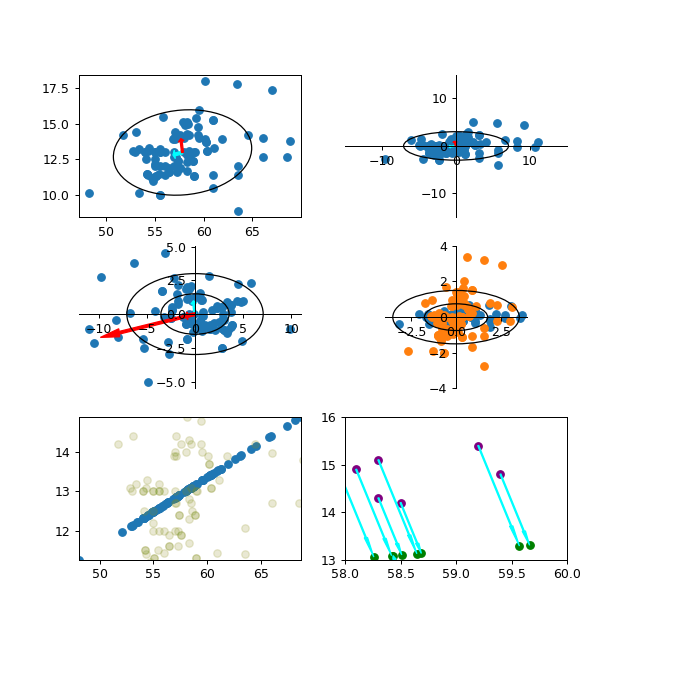

In [328]:
#Question 17
def SVDRebuild(U,S,V,k):
    rows,cols = V.shape
    res = np.zeros((rows,cols))
    for i in range(k):
        res += np.outer(U[:,i],V[i])*S[i,i]
    return res

#get U1S1Vt1
U1S1Vt1 = SVDRebuild(U,np.diag(S),Vt,1).T

#separate x,y values, add back averages 
U1S1Vt1_circ = U1S1Vt1[:,0] + avg_circ
U1S1Vt1_height = U1S1Vt1[:,1] + avg_height

#set axes min,max 
ax[2,0].set(xlim=(np.amin(U1S1Vt1_circ), np.amax(U1S1Vt1_circ)), ylim=(np.amin(U1S1Vt1_height), np.amax(U1S1Vt1_height)))

#plot data 
ax[2,0].scatter(U1S1Vt1_circ,U1S1Vt1_height)
fig

#the scatter plot is a line if we ignore the outliers 

What you just computed in Question 17 is the projection of the data onto the first principal axis. Just as with image compression from the previous lab, we have have effectively reduced the dimension of the data.

**Question 18** Add the original data to your last scatter plot (in a different color, perhaps transparently -- using *alpha*) and compare the projection to the original. On the sixth and last plot, pick a few points in your data and draw arrows from the original points to their projections. You may want to use a higher zoom level so the arrows are distinct and clear.

[58.5 59.2 58.3 57.9 58.1 57.1 59.4 58.3 57.3 58.5]
[14.2 15.4 14.3 15.1 14.9 14.4 14.8 15.1 12.  12.7]
[58.68786054 59.57147702 58.51090318 58.25928485 58.41919281 57.36391199
 59.66318738 58.64729838 57.14873315 58.43211954]
[13.13115842 13.28646363 13.10005623 13.05583157 13.08393714 12.89846005
 13.30258273 13.12402918 12.86064003 13.08620915]


<IPython.core.display.Javascript object>


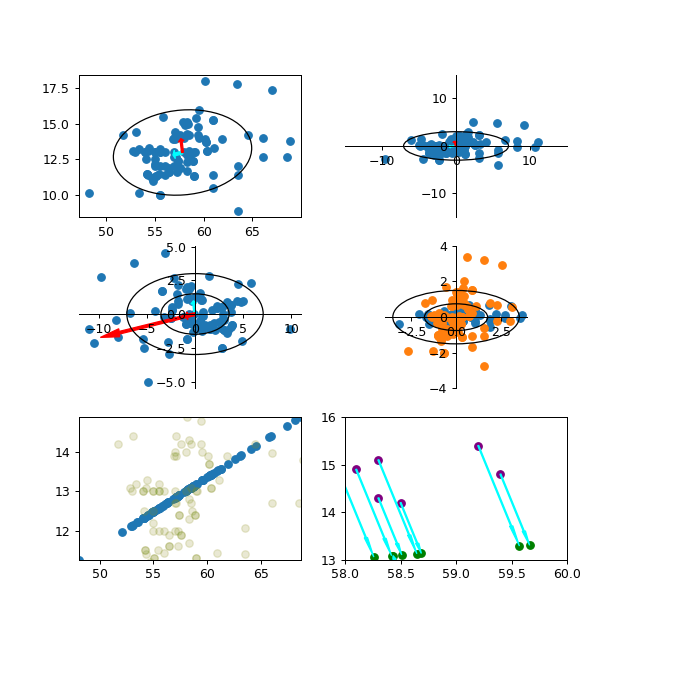

In [331]:
ax[0,1].axis([-15,15,-15,15])

#Question 18 
ax[2,1].clear()
#add original data to projection 
ax[2,0].scatter(faces_circ,faces_height,alpha=0.1)

#set sample size
sample_size = 10


#get sample points of projection 
sample_projection_circ = U1S1Vt1_circ[0:sample_size] 
sample_projection_height = U1S1Vt1_height[0:sample_size]

#get sample points of original 
sample_original_circ = faces_circ[0:sample_size] 
sample_original_height = faces_height[0:sample_size]

print(sample_original_circ)
print(sample_original_height)

print(sample_projection_circ)
print(sample_projection_height)

#plot points in graph [2,1]
ax[2,1].axis([58,60,13,16])
ax[2,1].scatter(sample_original_circ,sample_original_height, c="purple")
ax[2,1].scatter(sample_projection_circ,sample_projection_height, c="green")

#draw arrows between original and projection
#ax[2,1].add_patch(Arrow(sample_original_circ[0],sample_original_height[0],sample_projection_circ[0],sample_projection_height[0], color="cyan"))

for i in range(sample_size):
    startx = sample_original_circ[i]
    starty = sample_original_height[i]
    endx = sample_projection_circ[i] - sample_original_circ[i] 
    endy = sample_projection_height[i] - sample_original_height[i] 
    ax[2,1].add_patch(Arrow(startx,starty,endx,endy, color="cyan",width=0.05))
fig

If the second singular value is indeed much smaller than the first, this will not result in the loss of much information. If you're only given the location along this line of a point, you can figure out which face it came from with reasonable certainty - since there are many points, if the ellipse is narrow, two points are unlikely to project onto the very same one along the line. We say that the *effective dimension* of the data is one.

In the next lab, we will use exactly this idea in much higher dimension: by projecting data in 200 dimensions onto just the first ten principal axes, we will find that we lose remarkably little information. Enough, in fact, to train our code to be pretty darn good at reconginizing faces.